In [1]:
# Import necessary libraries
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
import cv2
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import os
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.layers import Input, Flatten, Dense
from tensorflow.keras.applications import VGG16
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [2]:
!pip install roboflow

from roboflow import Roboflow
rf = Roboflow(api_key="HA6CUY3Vdt1sRtv6vmzQ")
project = rf.workspace("nizar-assad").project("pistols-lhjbh")
dataset = project.version(1646).download("tensorflow")

You should consider upgrading via the 'C:\Users\assad\Desktop\weapon detection\venv\Scripts\python.exe -m pip install --upgrade pip' command.


loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to Pistols-1646 in tensorflow:: 100%|██████████| 4355/4355 [00:02<00:00, 1881.29it/s]


In [ ]:
# Paths to training set
annotations_path = 'C:\\Users\\assad\\Desktop\\weapon detection\\Gun-detection-2\\train\\_annotations.csv'
image_path_prefix = 'C:\\Users\\assad\\Desktop\\weapon detection\\Gun-detection-2\\train\\'


# Lists to store data, targets, and filenames
data = []
targets = []
filenames = []

# Read the CSV file
annotations = pd.read_csv(annotations_path)

# Explore the distribution of annotations
annotation_distribution = annotations['class'].value_counts()
print("Annotation Distribution:")
print(annotation_distribution)

Annotation Distribution:
class
Gun    2960
Name: count, dtype: int64


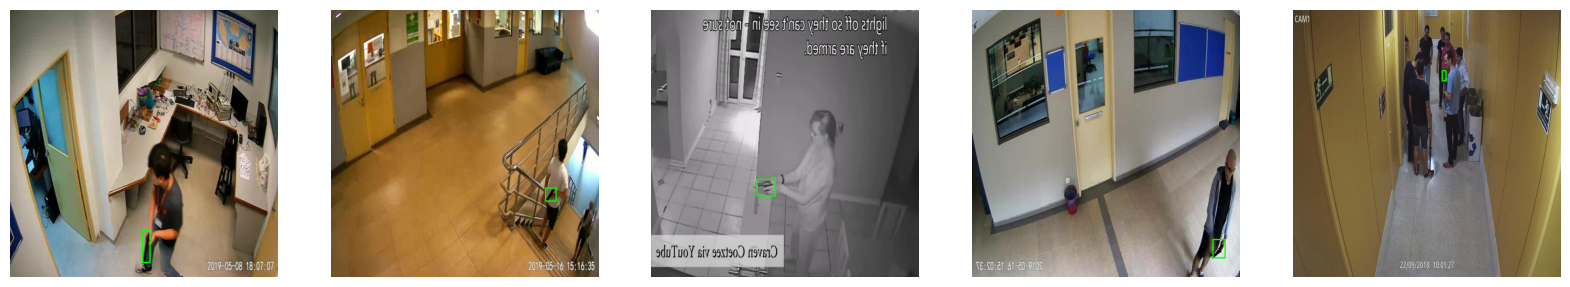

In [ ]:
annotations['image_path'] = image_path_prefix + annotations['filename']
# Visualize a batch of images with annotations and bounding boxes
num_images_to_visualize = 5
fig, axs = plt.subplots(1, num_images_to_visualize, figsize=(20, 20))

for i, (index, row) in enumerate(annotations.head(num_images_to_visualize).iterrows()):
    img_path = row['image_path']
    img = load_img(img_path)
    img_array = img_to_array(img)

    # Add bounding box to the image
    xmin, ymin, xmax, ymax = row['xmin'], row['ymin'], row['xmax'], row['ymax']
    cv2.rectangle(img_array, (xmin, ymin), (xmax, ymax), (0, 255, 0), 2)  # Green rectangle

    # Concatenate images horizontally
    axs[i].imshow(img_array.astype(np.uint8))
    axs[i].axis('off')  # Remove axis labels

plt.show()

In [ ]:
for index, row in annotations.iterrows():
    filename = row['filename']
    xmin, ymin, xmax, ymax = row['xmin'], row['ymin'], row['xmax'], row['ymax']

    image_path = os.path.join(image_path_prefix, filename)
    image = cv2.imread(image_path)
    (h, w) = image.shape[:2]

    # Initializing starting point
    startX = float(xmin) / w
    startY = float(ymin) / h
    # Initializing ending point
    endX = float(xmax) / w
    endY = float(ymax) / h

    # Load image and resize
    image = load_img(image_path, target_size=(224, 224))
    image = img_to_array(image)

    # Append into data, targets, filenames
    targets.append((startX, startY, endX, endY))
    filenames.append(filename)
    data.append(image)

In [ ]:
# Normalizing Data here also we face would face issues if we take input as integer
data=np.array(data,dtype='float32') / 255.0
targets=np.array(targets,dtype='float32')

In [ ]:
# Shuffle data and targets together
indices = np.arange(len(data))
np.random.shuffle(indices)

data = data[indices]
targets = targets[indices]

In [ ]:
# Split the data into training and testing sets
train_images, test_images, train_targets, test_targets = train_test_split(data,targets, test_size=0.1, random_state=42)

We wil display some random images to see if the bounding boxes are correctly shown in the visualizations, it indicates that the processing, including normalization and shuffling, has been done correctly. The visual inspection of the bounding boxes within the images provides a practical way to verify that the data preprocessing aligns with the expectations.

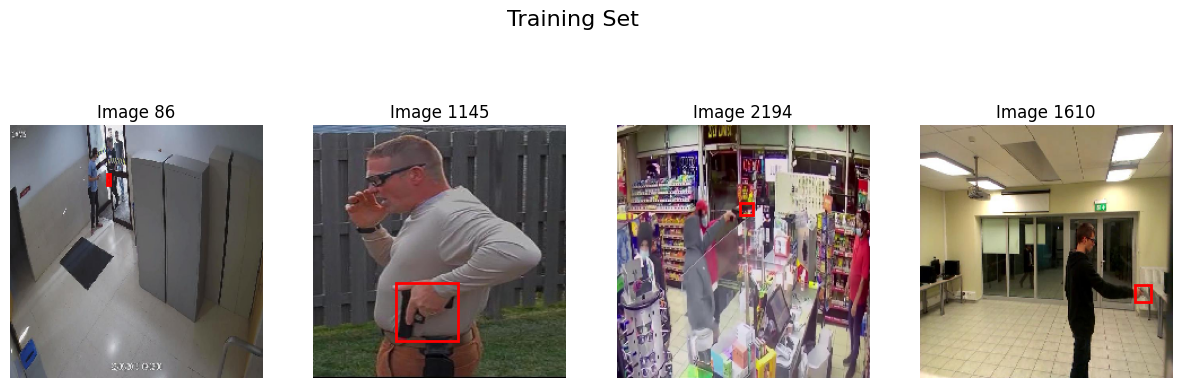

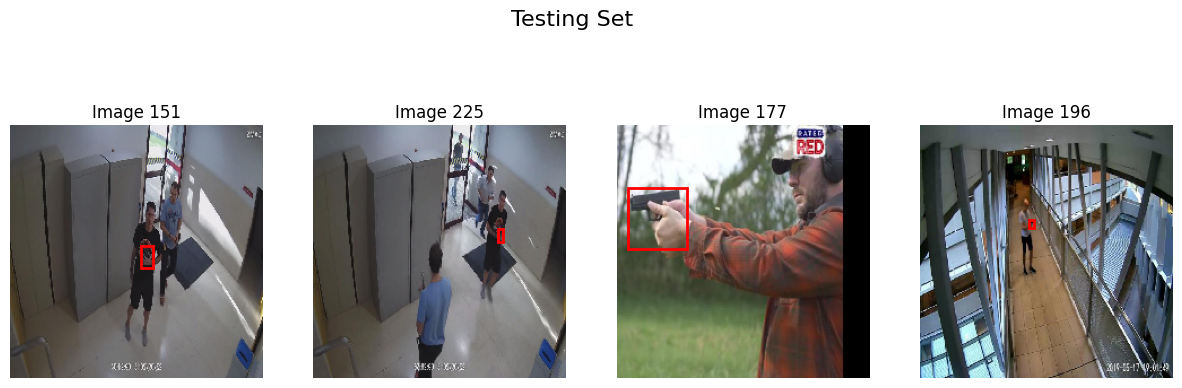

In [ ]:


def plot_images_with_boxes(images, boxes, title):
    num_images = len(images)

    # Generate random indices for selecting images to display
    random_indices = np.random.choice(num_images, size=min(num_images, 4), replace=False)

    fig, axes = plt.subplots(1, len(random_indices), figsize=(15, 5))
    fig.suptitle(title, fontsize=16)

    for i, idx in enumerate(random_indices):
        # Plot image
        axes[i].imshow(images[idx])

        # Get bounding box coordinates
        box = boxes[idx]

        # Convert normalized coordinates to pixel values
        h, w, _ = images[idx].shape
        start_x, start_y, end_x, end_y = box[0] * w, box[1] * h, box[2] * w, box[3] * h

        # Calculate width and height from start and end points
        width, height = end_x - start_x, end_y - start_y

        # Create a rectangle patch
        rect = patches.Rectangle((start_x, start_y), width, height, linewidth=2, edgecolor='r', facecolor='none')

        # Add the rectangle to the Axes
        axes[i].add_patch(rect)

        axes[i].axis('off')
        axes[i].set_title(f"Image {idx + 1}")

    plt.show()

# Plot random images with bounding boxes for both training and testing sets
plot_images_with_boxes(train_images, train_targets, title="Training Set")
plot_images_with_boxes(test_images, test_targets, title="Testing Set")


In [ ]:
print("Training set shape:", train_images.shape,train_targets.shape)
print("Validation set shape:", test_images.shape, test_targets.shape)

Training set shape: (2664, 224, 224, 3) (2664, 4)
Validation set shape: (296, 224, 224, 3) (296, 4)


# First training
lr = 1e-4,
loss = "mse",
batch_size = 32,
epochs = 50

In [ ]:
# Load pre-trained VGG16 model
vgg = VGG16(weights='imagenet', include_top=False, input_tensor=Input(shape=(224, 224, 3)))
vgg.trainable = False

# Flatten the output of VGG16
flatten = Flatten()(vgg.output)

# Additional custom layers for bounding box regression
bboxhead = Dense(128, activation="relu")(flatten)
bboxhead = Dense(128, activation="relu")(bboxhead)
bboxhead = Dense(64, activation="relu")(bboxhead)
bboxhead = Dense(32, activation="relu")(bboxhead)

# Output layer for bounding box regression
bbox_output = Dense(4, activation="linear")(bboxhead)  # Changed activation to 'linear'

# Create the model
model = Model(inputs=vgg.input, outputs=bbox_output)

# Compile the model with Mean Squared Error (MSE) loss and Adam optimizer
opt = Adam(learning_rate=1e-4)
model.compile(loss='mse', optimizer=opt)


In [ ]:
model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

In [ ]:
# Define callbacks
checkpoint = ModelCheckpoint('vgg16.h5', save_best_only=True)
early_stopping = EarlyStopping(patience=3, restore_best_weights=True)

# Train the model with the ModelCheckpoint callback
history = model.fit(train_images,train_targets,
                    validation_data=(test_images, test_targets),
                    batch_size=32,epochs=50,verbose=1,
                    callbacks=[checkpoint, early_stopping]
)

Epoch 1/50
84/84 [==============================] - ETA: 0s - loss: 0.0489

c:\Users\assad\Desktop\weapon detection\venv\lib\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


84/84 [==============================] - 281s 3s/step - loss: 0.0489 - val_loss: 0.0189
Epoch 2/50
84/84 [==============================] - 279s 3s/step - loss: 0.0184 - val_loss: 0.0179
Epoch 3/50
84/84 [==============================] - 276s 3s/step - loss: 0.0144 - val_loss: 0.0154
Epoch 4/50
84/84 [==============================] - 277s 3s/step - loss: 0.0123 - val_loss: 0.0144
Epoch 5/50
84/84 [==============================] - 271s 3s/step - loss: 0.0109 - val_loss: 0.0134
Epoch 6/50
84/84 [==============================] - 255s 3s/step - loss: 0.0093 - val_loss: 0.0133
Epoch 7/50
84/84 [==============================] - 254s 3s/step - loss: 0.0085 - val_loss: 0.0133
Epoch 8/50
84/84 [==============================] - 273s 3s/step - loss: 0.0077 - val_loss: 0.0138
Epoch 9/50
84/84 [==============================] - 271s 3s/step - loss: 0.0074 - val_loss: 0.0129
Epoch 10/50
84/84 [==============================] - 269s 3s/step - loss: 0.0066 - val_loss: 0.0122
Epoch 11/50
84/84 [=

In [ ]:
from tensorflow.keras.models import load_model
model=load_model('C:\\Users\\assad\\Desktop\\weapon detection\\vgg16.h5')

In [ ]:
import pandas as pd
from tensorflow.keras.preprocessing import image
import numpy as np
# Set the path to the test annotations CSV file
test_annotations_path = 'C:\\Users\\assad\\Desktop\\weapon detection\\Gun-detection-2\\test\\_annotations.csv'
test_image_path_prefix = 'C:\\Users\\assad\\Desktop\\weapon detection\\Gun-detection-2\\test\\'

# Load test annotations
test_annotations = pd.read_csv(test_annotations_path)

# Function to load and preprocess images
def load_images(image_paths):
    images = []
    for path in image_paths:
        img = image.load_img(path, target_size=(224, 224))
        img = image.img_to_array(img)
        img = img / 255.0  # Normalize pixel values
        images.append(img)
    return np.array(images)

# Load test images
test_image_paths = [test_image_path_prefix + filename for filename in test_annotations['filename']]
test_images = load_images(test_image_paths)


In [ ]:
import os
import cv2
import numpy as np
import pandas as pd

# Lists to store test data, targets, and filenames
test_data = []
test_targets = []
test_filenames = []

# Iterate over test annotations
for index, row in test_annotations.iterrows():
    filename = row['filename']
    xmin, ymin, xmax, ymax = row['xmin'], row['ymin'], row['xmax'], row['ymax']

    image_path = os.path.join(test_image_path_prefix, filename)
    image = cv2.imread(image_path)
    (h, w) = image.shape[:2]

    # Initializing starting point
    startX = float(xmin) / w
    startY = float(ymin) / h
    # Initializing ending point
    endX = float(xmax) / w
    endY = float(ymax) / h

    # Load image and resize
    image = load_img(image_path, target_size=(224, 224))
    image = img_to_array(image)

    # Append into test_data, test_targets, test_filenames
    test_targets.append((startX, startY, endX, endY))
    test_filenames.append(filename)
    test_data.append(image)

# Convert test_data and test_targets to numpy arrays
test_data = np.array(test_data, dtype='float32') / 255.0
test_targets = np.array(test_targets, dtype='float32')

# Perform inference using the loaded model
predictions = model.predict(test_data)


7/7 [==============================] - 23s 3s/step


In [ ]:
# Evaluate the model
print("Evaluation Metrics:")
print("====================")
print("Mean Squared Error:", mean_squared_error(test_targets, predictions))
print("Mean Absolute Error:", mean_absolute_error(test_targets, predictions))

# Optionally, you can also print the R2 score
print("R2 Score:", r2_score(test_targets, predictions))


Evaluation Metrics:
Mean Squared Error: 0.010949152
Mean Absolute Error: 0.074882455
R2 Score: 0.7127447086358148


In [ ]:
import numpy as np
from sklearn.metrics import precision_score, recall_score, accuracy_score

threshold = 0.5
predicted_labels = (predictions > threshold).astype(int)


# Convert it to a binary format for evaluation metrics
binary_test_targets = (test_targets > threshold).astype(int)

# Calculate metrics
precision = precision_score(binary_test_targets, predicted_labels, average='weighted')
recall = recall_score(binary_test_targets, predicted_labels, average='weighted')

print(f'Precision: {precision}')
print(f'Recall: {recall}')

Precision: 0.8628140739775013
Recall: 0.8523489932885906


# Second training
lr = 1e-4,
loss = "mse",
batch_size = 32,
epochs = 20

In [ ]:
# Constants
BATCH_SIZE = 32

# Load CSV annotations
annotations_path = "C:\\Users\\assad\\Desktop\\weapon detection\\Pistols-1646\\train\\_annotations.csv"
annotations_df = pd.read_csv(annotations_path)

# Split dataset into training and validation
train_df, val_df = train_test_split(annotations_df, test_size=0.2, random_state=42)

# Function to extract bounding box coordinates from DataFrame
def get_bounding_box(row):
    xmin = row['xmin'] / row['width']
    ymin = row['ymin'] / row['height']
    xmax = row['xmax'] / row['width']
    ymax = row['ymax'] / row['height']
    return np.array([xmin, ymin, xmax, ymax])

# Custom data generator
def custom_data_generator(data_frame, batch_size=BATCH_SIZE):
    while True:
        batch_indices = np.random.choice(len(data_frame), size=batch_size, replace=True)
        batch_df = data_frame.iloc[batch_indices]

        images = []
        bounding_boxes = []

        for _, row in batch_df.iterrows():
            image_path = os.path.join(image_directory, row['filename'])
            image = load_img(image_path, target_size=(224, 224))
            image = img_to_array(image) / 255.0
            images.append(image)

            bounding_box = get_bounding_box(row)
            bounding_boxes.append(bounding_box)

        images = np.array(images)
        bounding_boxes = np.array(bounding_boxes)

        yield images, bounding_boxes

In [ ]:
# Quick check of the loaded training data
sample_batch = next(custom_data_generator(train_df, image_directory))

# Extract images and bounding boxes from the batch
sample_images, sample_bounding_boxes = sample_batch

# Display information about the loaded data
print("Sample images shape:", sample_images.shape)
print("Sample bounding boxes shape:", sample_bounding_boxes.shape)

# Optionally, you can visualize a few examples
num_examples_to_visualize = 3

for i in range(num_examples_to_visualize):
    # Choose a random index from the batch
    index = np.random.randint(0, BATCH_SIZE)

    # Extract image and bounding box for visualization
    example_image = sample_images[index]
    example_bbox = sample_bounding_boxes[index]

    # Display information for the example
    print(f"\nExample {i + 1}:")
    print("Bounding Box Coordinates (xmin, ymin, xmax, ymax):", example_bbox)

    # Optionally, you can add code here to visualize the example image and bounding box
    # For example, using matplotlib or another visualization library
    # Add your visualization code here

    # Print a separator line for clarity
    print("-" * 40)


Sample images shape: (32, 224, 224, 3)
Sample bounding boxes shape: (32, 4)

Example 1:
Bounding Box Coordinates (xmin, ymin, xmax, ymax): [0.53571429 0.33928571 0.54910714 0.39285714]
----------------------------------------

Example 2:
Bounding Box Coordinates (xmin, ymin, xmax, ymax): [0.40178571 0.38839286 0.5        0.61160714]
----------------------------------------

Example 3:
Bounding Box Coordinates (xmin, ymin, xmax, ymax): [0.39732143 0.62946429 0.49107143 0.75446429]
----------------------------------------


In [ ]:
# Load pre-trained VGG16 model
vgg = VGG16(weights='imagenet', include_top=False, input_tensor=Input(shape=(224, 224, 3)))
vgg.trainable = False

# Flatten the output of VGG16
flatten = Flatten()(vgg.output)

# Additional custom layers for bounding box regression
bboxhead = Dense(128, activation="relu")(flatten)
bboxhead = Dense(128, activation="relu")(bboxhead)
bboxhead = Dense(64, activation="relu")(bboxhead)
bboxhead = Dense(32, activation="relu")(bboxhead)

# Output layer for bounding box regression
bbox_output = Dense(4, activation="linear")(bboxhead)

# Create the model
model = Model(inputs=vgg.input, outputs=bbox_output)

# Compile the model with Mean Squared Error (MSE) loss and Adam optimizer
opt = Adam(learning_rate=1e-4)
model.compile(loss='mse', optimizer=opt)

# Set up callbacks
checkpoint = ModelCheckpoint("gun_detection_model.h5", monitor='val_loss', save_best_only=True, verbose=1)
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1)

# Train the model
history = model.fit(
    custom_data_generator(train_df),
    steps_per_epoch=len(train_df) // BATCH_SIZE,
    validation_data=custom_data_generator(val_df),
    validation_steps=len(val_df) // BATCH_SIZE,
    epochs=20,
    callbacks=[checkpoint, early_stopping]
)

# Save the final model
model.save("gun_detection_model_final.h5")

Epoch 1/20
100/100 [==============================] - ETA: 0s - loss: 0.0323
Epoch 1: val_loss improved from inf to 0.02466, saving model to gun_detection_model.h5
100/100 [==============================] - 341s 3s/step - loss: 0.0323 - val_loss: 0.0247
Epoch 2/20


You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.


100/100 [==============================] - ETA: 0s - loss: 0.0170
Epoch 2: val_loss improved from 0.02466 to 0.02051, saving model to gun_detection_model.h5
100/100 [==============================] - 339s 3s/step - loss: 0.0170 - val_loss: 0.0205
Epoch 3/20
100/100 [==============================] - ETA: 0s - loss: 0.0125
Epoch 3: val_loss improved from 0.02051 to 0.01876, saving model to gun_detection_model.h5
100/100 [==============================] - 334s 3s/step - loss: 0.0125 - val_loss: 0.0188
Epoch 4/20
100/100 [==============================] - ETA: 0s - loss: 0.0107
Epoch 4: val_loss improved from 0.01876 to 0.01501, saving model to gun_detection_model.h5
100/100 [==============================] - 334s 3s/step - loss: 0.0107 - val_loss: 0.0150
Epoch 5/20
100/100 [==============================] - ETA: 0s - loss: 0.0094
Epoch 5: val_loss did not improve from 0.01501
100/100 [==============================] - 336s 3s/step - loss: 0.0094 - val_loss: 0.0151
Epoch 6/20
100/100 [===

In [ ]:
import pandas as pd
from tensorflow.keras.preprocessing import image
import numpy as np
# Set the path to the test annotations CSV file
test_annotations_path = 'C:\\Users\\assad\\Desktop\\weapon detection\\Pistols-1646\\test\\_annotations.csv'
test_image_path_prefix = 'C:\\Users\\assad\\Desktop\\weapon detection\\Pistols-1646\\test\\'

# Load test annotations
test_annotations = pd.read_csv(test_annotations_path)

# Function to load and preprocess images
def load_images(image_paths):
    images = []
    for path in image_paths:
        img = image.load_img(path, target_size=(224, 224))
        img = image.img_to_array(img)
        img = img / 255.0  # Normalize pixel values
        images.append(img)
    return np.array(images)

# Load test images
test_image_paths = [test_image_path_prefix + filename for filename in test_annotations['filename']]
test_images = load_images(test_image_paths)

In [ ]:
import os
import cv2
import numpy as np
import pandas as pd

# Lists to store test data, targets, and filenames
test_data = []
test_targets = []
test_filenames = []

# Iterate over test annotations
for index, row in test_annotations.iterrows():
    filename = row['filename']
    xmin, ymin, xmax, ymax = row['xmin'], row['ymin'], row['xmax'], row['ymax']

    image_path = os.path.join(test_image_path_prefix, filename)
    image = cv2.imread(image_path)
    (h, w) = image.shape[:2]

    # Initializing starting point
    startX = float(xmin) / w
    startY = float(ymin) / h
    # Initializing ending point
    endX = float(xmax) / w
    endY = float(ymax) / h

    # Load image and resize
    image = load_img(image_path, target_size=(224, 224))
    image = img_to_array(image)

    # Append into test_data, test_targets, test_filenames
    test_targets.append((startX, startY, endX, endY))
    test_filenames.append(filename)
    test_data.append(image)

# Convert test_data and test_targets to numpy arrays
test_data = np.array(test_data, dtype='float32') / 255.0
test_targets = np.array(test_targets, dtype='float32')

# Perform inference using the loaded model
predictions = model.predict(test_data)

8/8 [==============================] - 20s 2s/step


In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Evaluate the model
print("Evaluation Metrics:")
print("====================")
print("Mean Squared Error:", mean_squared_error(test_targets, predictions))
print("Mean Absolute Error:", mean_absolute_error(test_targets, predictions))

# Optionally, you can also print the R2 score
from sklearn.metrics import r2_score
print("R2 Score:", r2_score(test_targets, predictions))
import numpy as np
from sklearn.metrics import precision_score, recall_score, accuracy_score

# Assuming predictions and test_targets are in the same format (shape)
# Adjust the threshold based on your needs
threshold = 0.5
predicted_labels = (predictions > threshold).astype(int)

# Assuming test_targets is a multi-output array
# Convert it to a binary format for evaluation metrics
binary_test_targets = (test_targets > threshold).astype(int)

# Calculate metrics
precision = precision_score(binary_test_targets, predicted_labels, average='weighted')
recall = recall_score(binary_test_targets, predicted_labels, average='weighted')

print(f'Precision: {precision}')
print(f'Recall: {recall}')

Evaluation Metrics:
Mean Squared Error: 0.024081826
Mean Absolute Error: 0.11482484
R2 Score: 0.3401779257373454
Precision: 0.7566755035243969
Recall: 0.7415730337078652


# Third training
lr = 1e-3,
loss = "mse",
batch_size = 16,
epochs = 20

In [ ]:
# Load pre-trained VGG16 model
vgg = VGG16(weights='imagenet', include_top=False, input_tensor=Input(shape=(224, 224, 3)))
vgg.trainable = False

# Flatten the output of VGG16
flatten = Flatten()(vgg.output)

# Additional custom layers for bounding box regression
bboxhead = Dense(128, activation="relu")(flatten)
bboxhead = Dense(128, activation="relu")(bboxhead)
bboxhead = Dense(64, activation="relu")(bboxhead)
bboxhead = Dense(32, activation="relu")(bboxhead)

# Output layer for bounding box regression
bbox_output = Dense(4, activation="linear")(bboxhead)

# Create the model
model = Model(inputs=vgg.input, outputs=bbox_output)

# Compile the model with Mean Squared Error (MSE) loss and Adam optimizer
opt = Adam(learning_rate=1e-3)
model.compile(loss='mse', optimizer=opt)

# Set up callbacks
checkpoint = ModelCheckpoint("gun_detection_model.h5", monitor='val_loss', save_best_only=True, verbose=1)
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1)

BATCH_SIZE= 16

# Train the model
history = model.fit(
    custom_data_generator(train_df),
    steps_per_epoch=len(train_df) // BATCH_SIZE,
    validation_data=custom_data_generator(val_df),
    validation_steps=len(val_df) // BATCH_SIZE,
    epochs=20,
    callbacks=[checkpoint, early_stopping]
)

In [ ]:
import pandas as pd
from tensorflow.keras.preprocessing import image
import numpy as np
# Set the path to the test annotations CSV file
test_annotations_path = 'C:\\Users\\assad\\Desktop\\weapon detection\\Pistols-1646\\test\\_annotations.csv'
test_image_path_prefix = 'C:\\Users\\assad\\Desktop\\weapon detection\\Pistols-1646\\test\\'

# Load test annotations
test_annotations = pd.read_csv(test_annotations_path)

# Function to load and preprocess images
def load_images(image_paths):
    images = []
    for path in image_paths:
        img = image.load_img(path, target_size=(224, 224))
        img = image.img_to_array(img)
        img = img / 255.0  # Normalize pixel values
        images.append(img)
    return np.array(images)

# Load test images
test_image_paths = [test_image_path_prefix + filename for filename in test_annotations['filename']]
test_images = load_images(test_image_paths)

In [ ]:
import os
import cv2
import numpy as np
import pandas as pd

# Lists to store test data, targets, and filenames
test_data = []
test_targets = []
test_filenames = []

# Iterate over test annotations
for index, row in test_annotations.iterrows():
    filename = row['filename']
    xmin, ymin, xmax, ymax = row['xmin'], row['ymin'], row['xmax'], row['ymax']

    image_path = os.path.join(test_image_path_prefix, filename)
    image = cv2.imread(image_path)
    (h, w) = image.shape[:2]

    # Initializing starting point
    startX = float(xmin) / w
    startY = float(ymin) / h
    # Initializing ending point
    endX = float(xmax) / w
    endY = float(ymax) / h

    # Load image and resize
    image = load_img(image_path, target_size=(224, 224))
    image = img_to_array(image)

    # Append into test_data, test_targets, test_filenames
    test_targets.append((startX, startY, endX, endY))
    test_filenames.append(filename)
    test_data.append(image)

# Convert test_data and test_targets to numpy arrays
test_data = np.array(test_data, dtype='float32') / 255.0
test_targets = np.array(test_targets, dtype='float32')

# Perform inference using the loaded model
predictions = model.predict(test_data)

8/8 [==============================] - 20s 2s/step


In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Evaluate the model
print("Evaluation Metrics:")
print("====================")
print("Mean Squared Error:", mean_squared_error(test_targets, predictions))
print("Mean Absolute Error:", mean_absolute_error(test_targets, predictions))

# Optionally, you can also print the R2 score
from sklearn.metrics import r2_score
print("R2 Score:", r2_score(test_targets, predictions))
import numpy as np
from sklearn.metrics import precision_score, recall_score, accuracy_score

# Assuming predictions and test_targets are in the same format (shape)
# Adjust the threshold based on your needs
threshold = 0.5
predicted_labels = (predictions > threshold).astype(int)

# Assuming test_targets is a multi-output array
# Convert it to a binary format for evaluation metrics
binary_test_targets = (test_targets > threshold).astype(int)

# Calculate metrics
precision = precision_score(binary_test_targets, predicted_labels, average='weighted')
recall = recall_score(binary_test_targets, predicted_labels, average='weighted')

print(f'Precision: {precision}')
print(f'Recall: {recall}')

Evaluation Metrics:
Mean Squared Error: 0.022654153
Mean Absolute Error: 0.11131621
R2 Score: 0.3781763324938245
Precision: 0.75783460736263
Recall: 0.7325842696629213


# Fourth Session


In [ ]:
# Load pre-trained VGG16 model
vgg = VGG16(weights='imagenet', include_top=False, input_tensor=Input(shape=(224, 224, 3)))
vgg.trainable = False

# Flatten the output of VGG16
flatten = Flatten()(vgg.output)

# Additional custom layers for bounding box regression
bboxhead = Dense(128, activation="relu")(flatten)
bboxhead = Dense(128, activation="relu")(bboxhead)
bboxhead = Dense(64, activation="relu")(bboxhead)
bboxhead = Dense(32, activation="relu")(bboxhead)

# Output layer for bounding box regression
bbox_output = Dense(4, activation="linear")(bboxhead)

# Create the model
model = Model(inputs=vgg.input, outputs=bbox_output)

# Compile the model with Mean Squared Error (MSE) loss and Adam optimizer
opt = Adam(learning_rate=1e-3)
model.compile(loss='mse', optimizer=opt)

# Set up callbacks
checkpoint = ModelCheckpoint("gun_detection_model.h5", monitor='val_loss', save_best_only=True, verbose=1)
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1)

BATCH_SIZE= 32
# Train the model
history = model.fit(
    custom_data_generator(train_df),
    steps_per_epoch=len(train_df) // BATCH_SIZE,
    validation_data=custom_data_generator(val_df),
    validation_steps=len(val_df) // BATCH_SIZE,
    epochs=50,
    callbacks=[checkpoint, early_stopping]
)

# Save the final model
model.save("gun_detection_model_final.h5")

Epoch 1/50
100/100 [==============================] - ETA: 0s - loss: 0.0761
Epoch 1: val_loss improved from inf to 0.02884, saving model to gun_detection_model.h5
100/100 [==============================] - 330s 3s/step - loss: 0.0761 - val_loss: 0.0288
Epoch 2/50


You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.


100/100 [==============================] - ETA: 0s - loss: 0.0187
Epoch 2: val_loss improved from 0.02884 to 0.02013, saving model to gun_detection_model.h5
100/100 [==============================] - 316s 3s/step - loss: 0.0187 - val_loss: 0.0201
Epoch 3/50
100/100 [==============================] - ETA: 0s - loss: 0.0148
Epoch 3: val_loss did not improve from 0.02013
100/100 [==============================] - 336s 3s/step - loss: 0.0148 - val_loss: 0.0218
Epoch 4/50
100/100 [==============================] - ETA: 0s - loss: 0.0128
Epoch 4: val_loss improved from 0.02013 to 0.01454, saving model to gun_detection_model.h5
100/100 [==============================] - 337s 3s/step - loss: 0.0128 - val_loss: 0.0145
Epoch 5/50
100/100 [==============================] - ETA: 0s - loss: 0.0100
Epoch 5: val_loss improved from 0.01454 to 0.01261, saving model to gun_detection_model.h5
100/100 [==============================] - 335s 3s/step - loss: 0.0100 - val_loss: 0.0126
Epoch 6/50
100/100 [===

In [ ]:
import pandas as pd
from tensorflow.keras.preprocessing import image
import numpy as np
# Set the path to the test annotations CSV file
test_annotations_path = 'C:\\Users\\assad\\Desktop\\weapon detection\\Pistols-1646\\test\\_annotations.csv'
test_image_path_prefix = 'C:\\Users\\assad\\Desktop\\weapon detection\\Pistols-1646\\test\\'

# Load test annotations
test_annotations = pd.read_csv(test_annotations_path)

# Function to load and preprocess images
def load_images(image_paths):
    images = []
    for path in image_paths:
        img = image.load_img(path, target_size=(224, 224))
        img = image.img_to_array(img)
        img = img / 255.0  # Normalize pixel values
        images.append(img)
    return np.array(images)

# Load test images
test_image_paths = [test_image_path_prefix + filename for filename in test_annotations['filename']]
test_images = load_images(test_image_paths)

In [ ]:
import os
import cv2
import numpy as np
import pandas as pd

# Lists to store test data, targets, and filenames
test_data = []
test_targets = []
test_filenames = []

# Iterate over test annotations
for index, row in test_annotations.iterrows():
    filename = row['filename']
    xmin, ymin, xmax, ymax = row['xmin'], row['ymin'], row['xmax'], row['ymax']

    image_path = os.path.join(test_image_path_prefix, filename)
    image = cv2.imread(image_path)
    (h, w) = image.shape[:2]

    # Initializing starting point
    startX = float(xmin) / w
    startY = float(ymin) / h
    # Initializing ending point
    endX = float(xmax) / w
    endY = float(ymax) / h

    # Load image and resize
    image = load_img(image_path, target_size=(224, 224))
    image = img_to_array(image)

    # Append into test_data, test_targets, test_filenames
    test_targets.append((startX, startY, endX, endY))
    test_filenames.append(filename)
    test_data.append(image)

# Convert test_data and test_targets to numpy arrays
test_data = np.array(test_data, dtype='float32') / 255.0
test_targets = np.array(test_targets, dtype='float32')

# Perform inference using the loaded model
predictions = model.predict(test_data)

8/8 [==============================] - 20s 2s/step


In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Evaluate the model
print("Evaluation Metrics:")
print("====================")
print("Mean Squared Error:", mean_squared_error(test_targets, predictions))
print("Mean Absolute Error:", mean_absolute_error(test_targets, predictions))

# Optionally, you can also print the R2 score
from sklearn.metrics import r2_score
print("R2 Score:", r2_score(test_targets, predictions))
import numpy as np
from sklearn.metrics import precision_score, recall_score, accuracy_score

# Assuming predictions and test_targets are in the same format (shape)
# Adjust the threshold based on your needs
threshold = 0.5
predicted_labels = (predictions > threshold).astype(int)

# Assuming test_targets is a multi-output array
# Convert it to a binary format for evaluation metrics
binary_test_targets = (test_targets > threshold).astype(int)

# Calculate metrics
precision = precision_score(binary_test_targets, predicted_labels, average='weighted')
recall = recall_score(binary_test_targets, predicted_labels, average='weighted')

print(f'Precision: {precision}')
print(f'Recall: {recall}')

Evaluation Metrics:
Mean Squared Error: 0.023113772
Mean Absolute Error: 0.115429774
R2 Score: 0.3566059877309663
Precision: 0.756566624827652
Recall: 0.755056179775281


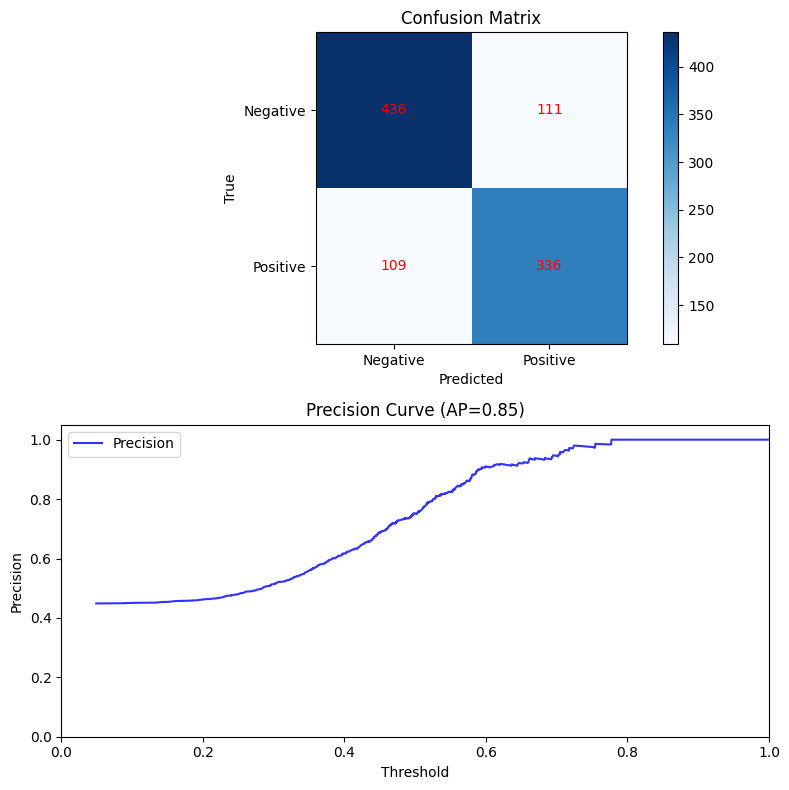

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, precision_recall_curve, average_precision_score, auc, f1_score
from sklearn.utils import class_weight

# Plot Confusion Matrix
cm = confusion_matrix(binary_test_targets.flatten(), predicted_labels.flatten())
plt.figure(figsize=(8, 8))

# Vertical confusion matrix
plt.subplot(2, 1, 1)
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
plt.xlabel('Predicted')
plt.ylabel('True')
plt.xticks([0, 1], ['Negative', 'Positive'])
plt.yticks([0, 1], ['Negative', 'Positive'])

# Display the values in the confusion matrix
for i in range(2):
    for j in range(2):
        plt.text(j, i, str(cm[i, j]), ha='center', va='center', color='red')

# Plot Precision curve
precision, recall, thresholds = precision_recall_curve(binary_test_targets.flatten(), predictions.flatten())
average_precision = average_precision_score(binary_test_targets.flatten(), predictions.flatten())
plt.subplot(2, 1, 2)
plt.plot(thresholds, precision[:-1], color='b', label='Precision', alpha=0.8)
plt.xlabel('Threshold')
plt.ylabel('Precision')
plt.title('Precision Curve')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title(f'Precision Curve (AP={average_precision:.2f})')
plt.legend()

plt.tight_layout()
plt.show()


# Testing the wining model

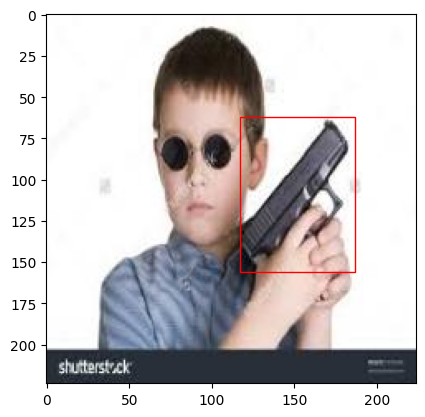

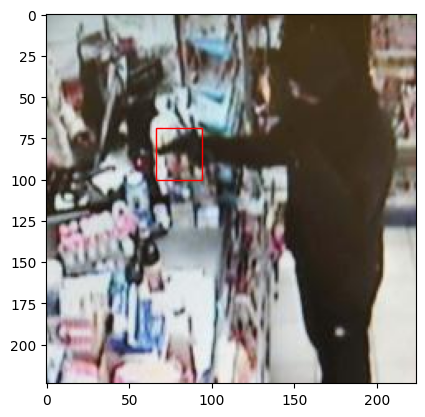

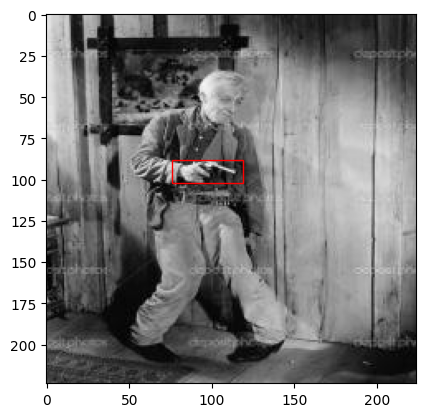

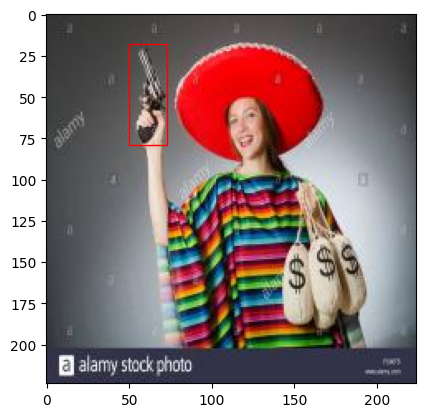

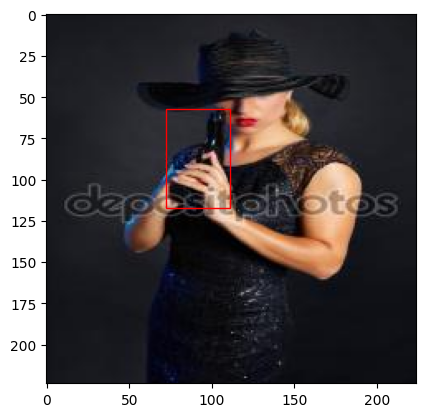

In [ ]:
# Display 5 images from the test set with predicted bounding boxes
for i in range(5):
    image_path = os.path.join(IMAGE_DIRECTORY, test_annotations_df['filename'].iloc[i])
    image = load_img(image_path)

    # Plot predicted bounding box
    pred_box = predictions[i] * 224
    plt.gca().add_patch(plt.Rectangle((pred_box[0], pred_box[1]), pred_box[2] - pred_box[0], pred_box[3] - pred_box[1], fill=False, color='red'))

    plt.show()